In [333]:
# Importing required modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Model Building
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.linear_model import LassoCV ,RidgeCV , ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Pipeline
from sklearn.pipeline import make_pipeline

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Pickle
import pickle

In [295]:
# Import data into notebook
df = pd.read_csv('/content/Walmart.csv')

In [296]:
# Head check
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [297]:
# Display cols
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [298]:
# Null check
df.isnull().any()

Store           False
Date            False
Weekly_Sales    False
Holiday_Flag    False
Temperature     False
Fuel_Price      False
CPI             False
Unemployment    False
dtype: bool

In [299]:
# Type check
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [300]:
for i in df.columns:
    print(f'{i}: {df[i].nunique()}')

Store: 45
Date: 143
Weekly_Sales: 6435
Holiday_Flag: 2
Temperature: 3528
Fuel_Price: 892
CPI: 2145
Unemployment: 349


In [301]:
# Convert Date to dateTime dtype
df['Date'] = pd.to_datetime(df.Date)

<ipython-input-301-fe8df487dfdc>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df.Date)


In [302]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [303]:
# Info on df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [304]:
# Unique rows in each col
df.nunique().sort_values()

Holiday_Flag       2
Store             45
Date             143
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64


**Data Cleaning**



In [305]:
# convert column names to lower case
df.columns = [col.lower() for col in df.columns ]

In [306]:
df.columns

Index(['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment'],
      dtype='object')

In [307]:
# split the date column
df['year']= df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df.head(5)

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,year,month,day
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,2010,5,2
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2010,12,2
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,19
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,26
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,2010,5,3


In [308]:
target = 'weekly_sales'
features = [i for i in df.columns if i not in [target]]

In [309]:
print('Minimum Sales: ',df.groupby('store')['weekly_sales'].sum().min())
print('Maximum Sales: ',df.groupby('store')['weekly_sales'].sum().max())

Minimum Sales:  37160221.96
Maximum Sales:  301397792.46


In [310]:
# Count the number of times each value appears in the 'Holiday_Flag' column.
df['holiday_flag'].value_counts()

0    5985
1     450
Name: holiday_flag, dtype: int64

In [311]:
# Outlier Check
def find_outlier_rows(df, col, level='both'):
    # compute the interquartile range
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)

    # compute the upper and lower bounds for identifying outliers
    lower_bound = df[col].quantile(0.25) - 1.5 * iqr
    upper_bound = df[col].quantile(0.75) + 1.5 * iqr

    # filter the rows based on the level of outliers to return
    if level == 'lower':
        return df[df[col] < lower_bound]
    elif level == 'upper':
        return df[df[col] > upper_bound]
    else:
        return df[(df[col] > upper_bound) | (df[col] < lower_bound)]

In [312]:
def count_outliers(df):
    # select numeric columns
    df_numeric = df.select_dtypes(include=['int', 'float'])

    # get column names
    columns = df_numeric.columns

    # find the name of all columns with outliers
    outlier_cols = [col for col in columns if len(find_outlier_rows(df_numeric, col)) != 0]

    # dataframe to store the results
    outliers_df = pd.DataFrame(columns=['outlier_counts', 'outlier_percent'])

    # count the outliers and compute the percentage of outliers for each column
    for col in outlier_cols:
        outlier_count = len(find_outlier_rows(df_numeric, col))
        all_entries = len(df[col])
        outlier_percent = round(outlier_count * 100 / all_entries, 2)

        # store the results in the dataframe
        outliers_df.loc[col] = [outlier_count, outlier_percent]

    # return the resulting dataframe
    return outliers_df

In [313]:
# Outlier count
count_outliers(df).sort_values('outlier_counts', ascending=False)

,outlier_counts,outlier_percent
unemployment,481.0,7.47
holiday_flag,450.0,6.99
weekly_sales,34.0,0.53
temperature,3.0,0.05


In [314]:
# Display employment rate
df['employment'] = 100 - df['unemployment']

In [315]:
# Summary stats
df.describe()

# Over a span of three years, from 2010 to 2012, there were weekly transactions recorded in a total of 45 stores.
# The highest weekly sales reached a peak of $3.8 million, and the highest recorded temperature during this period was 100°F.

,store,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,year,month,day,employment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,2010.965035,6.475524,15.650350,92.000849
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.797019,3.321797,8.753908,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000,1.000000,85.687000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,2010.000000,4.000000,8.000000,91.378000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,2011.000000,6.000000,16.000000,92.126000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,2012.000000,9.000000,23.000000,93.109000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,2012.000000,12.000000,31.000000,96.121000


In [316]:
# Remove any duplicate rows from the DataFrame.

# Count the number of rows in the original DataFrame.
original_row_count = df.shape[0]

# Drop any duplicate rows from the DataFrame.
df.drop_duplicates(inplace=True)

# Count the number of rows in the DataFrame after removing duplicates.
new_row_count = df.shape[0]

# No duplicates present

**EDA**

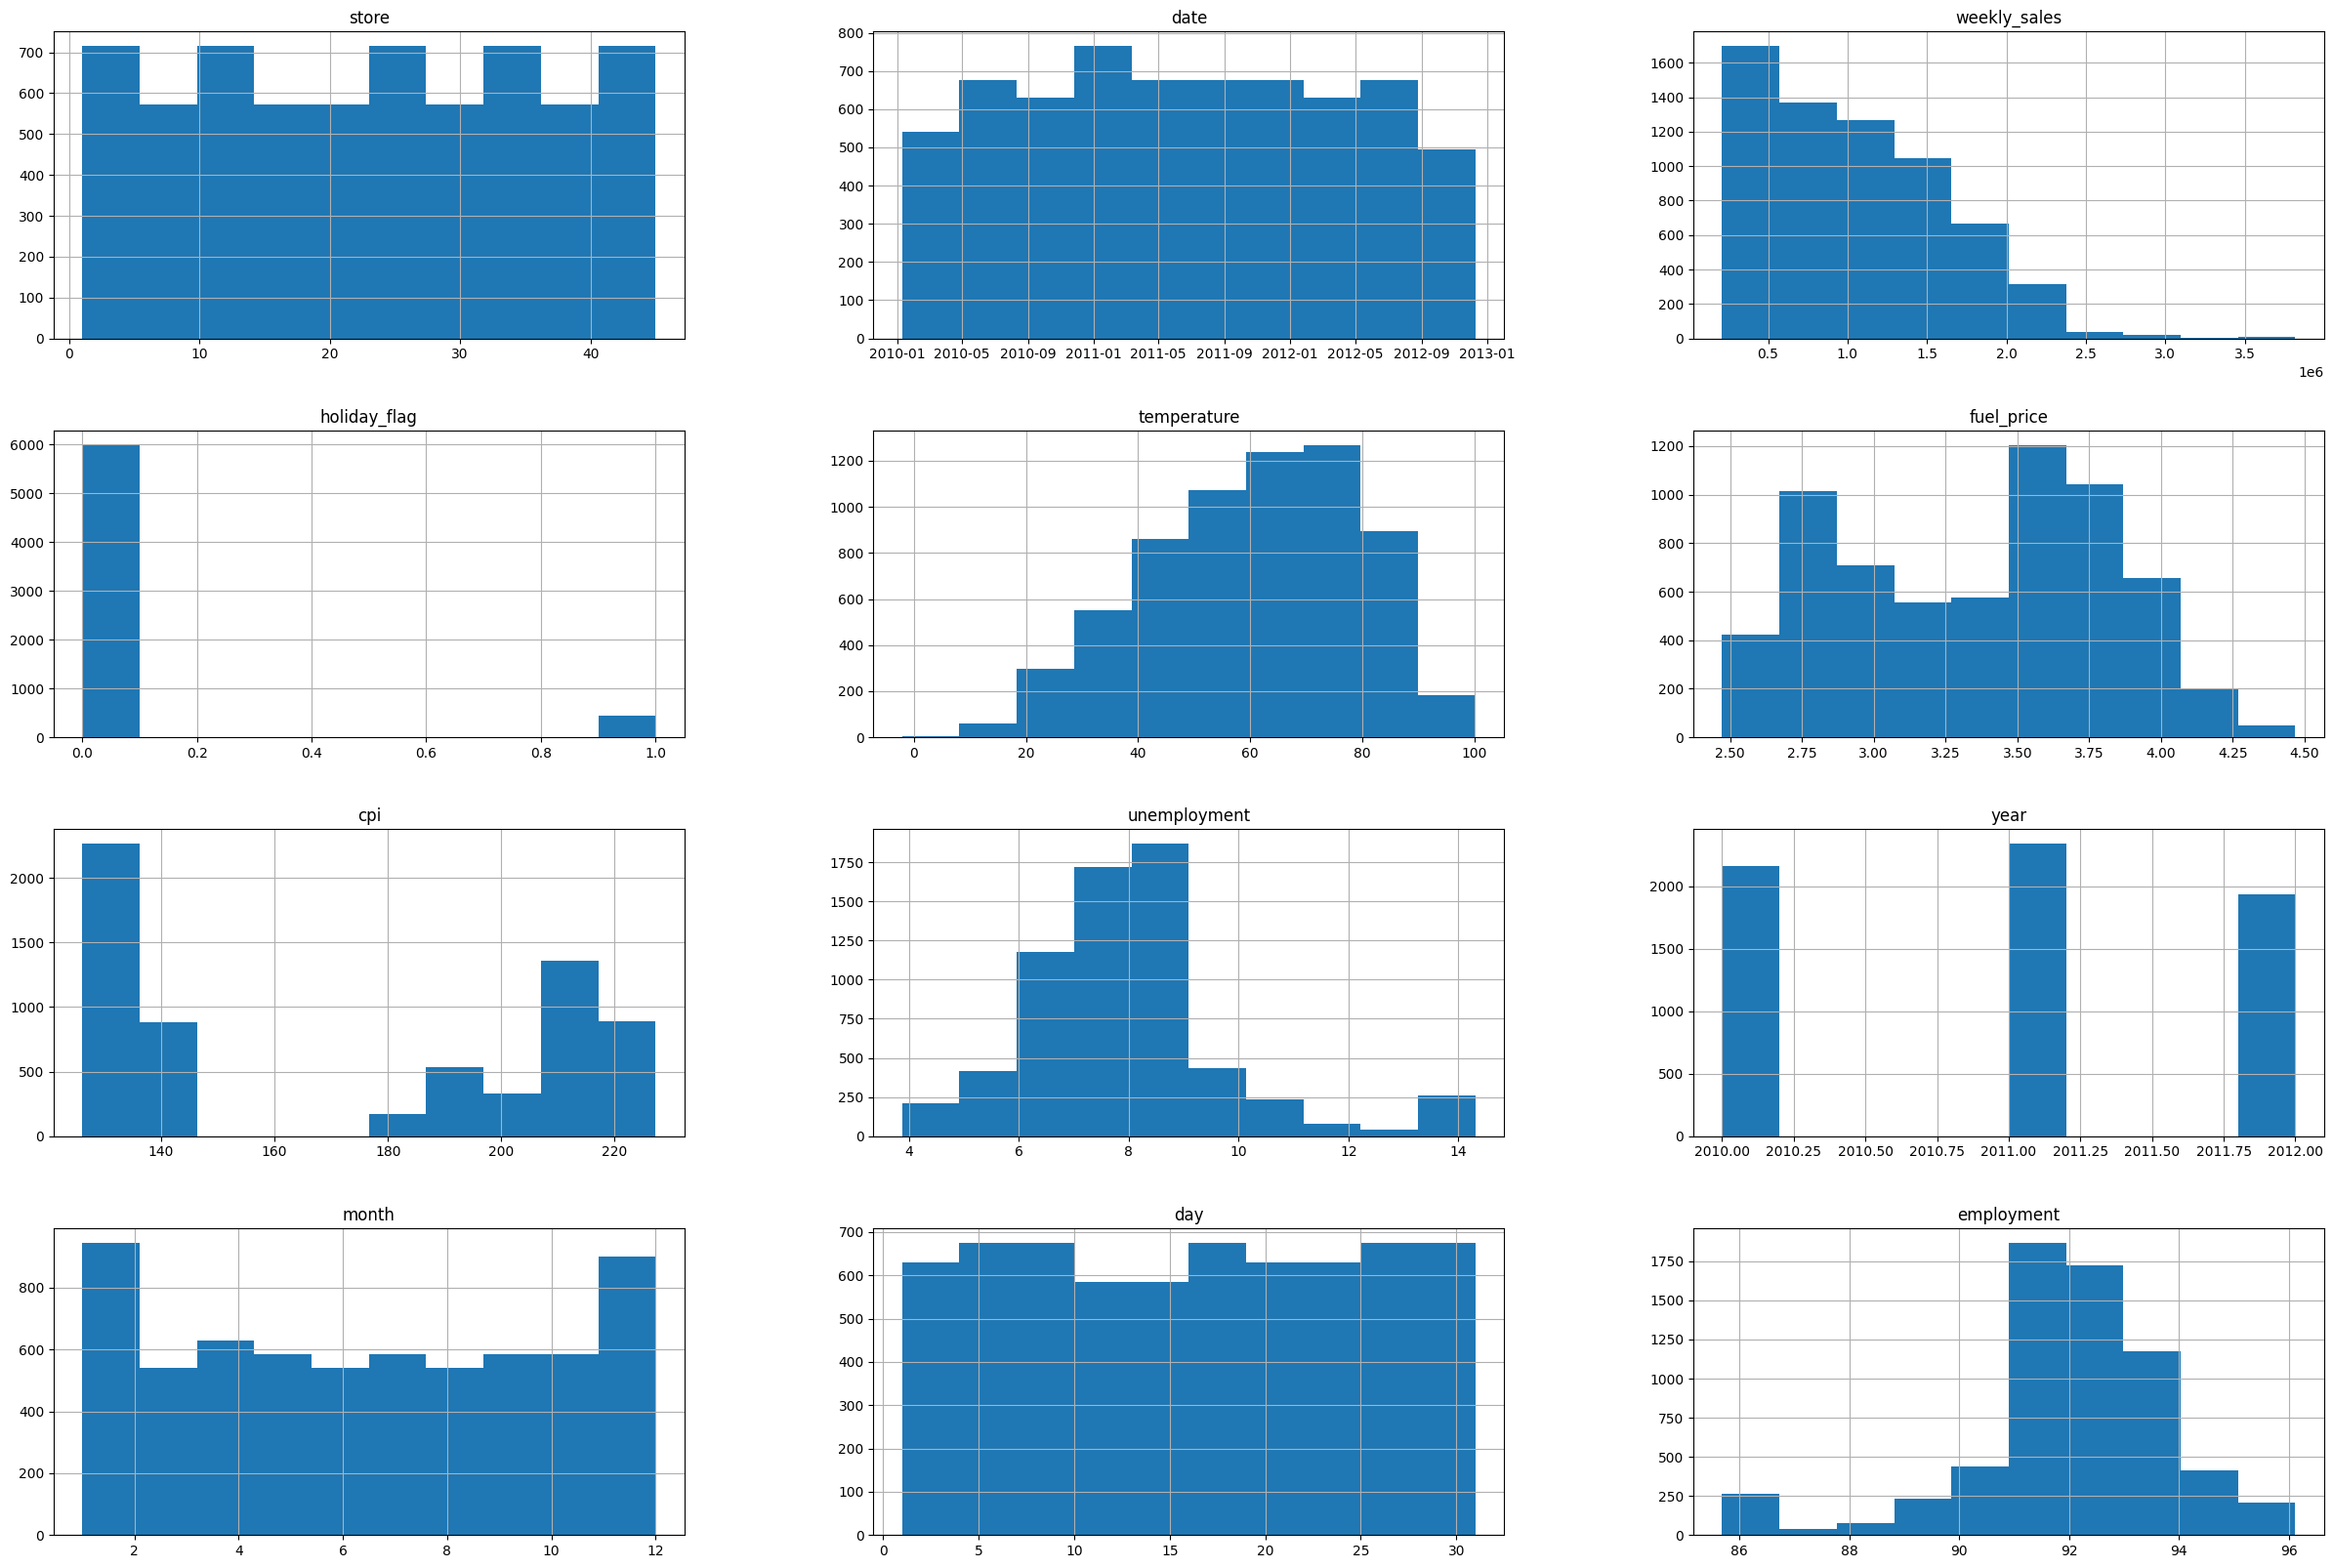

In [206]:
# histograms
df.hist(figsize=(30,20))
plt.show()

In [222]:
def average_sales_by_stores(dataframe, group_column):

    plt.figure(figsize=(4, 2))

    # Group the data by the specified column and sort it by average weekly sales in descending order
    grouped_data = df.groupby(group_column).mean().sort_values(by='weekly_sales', ascending=False)

    # Select the top 5 and bottom 5 stores
    top_stores = grouped_data.head(5)
    bottom_stores = grouped_data.tail(5)

    # Set the color palette
    sns.set_palette("bright")

    # Create a bar chart of the top 5 stores
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=top_stores.index, y=top_stores['weekly_sales'] / 1e6, order=top_stores.index)
    plt.title('Top 5 Stores by Average Weekly Sales')
    plt.ylabel('Average Weekly Sales (millions USD)')
    plt.xlabel(group_column)
    plt.show()

    # Create a bar chart of the bottom 5 stores
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=bottom_stores.index, y=bottom_stores['weekly_sales'] / 1e6, order=bottom_stores.index)
    plt.title('Bottom 5 Stores by Average Weekly Sales')
    plt.ylabel('Average Weekly Sales (millions USD)')
    plt.xlabel(group_column)
    plt.show()


<ipython-input-222-b2ce2255ca92>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = df.groupby(group_column).mean().sort_values(by='weekly_sales', ascending=False)


<Figure size 400x200 with 0 Axes>

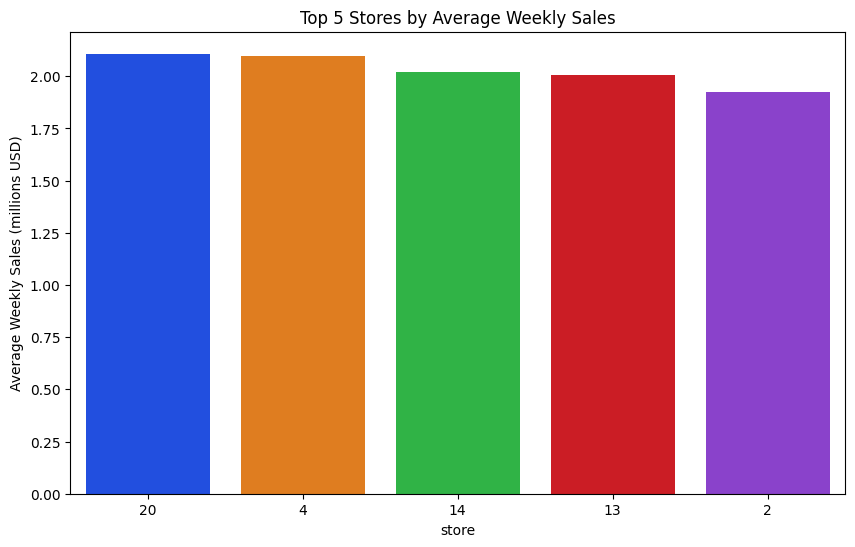

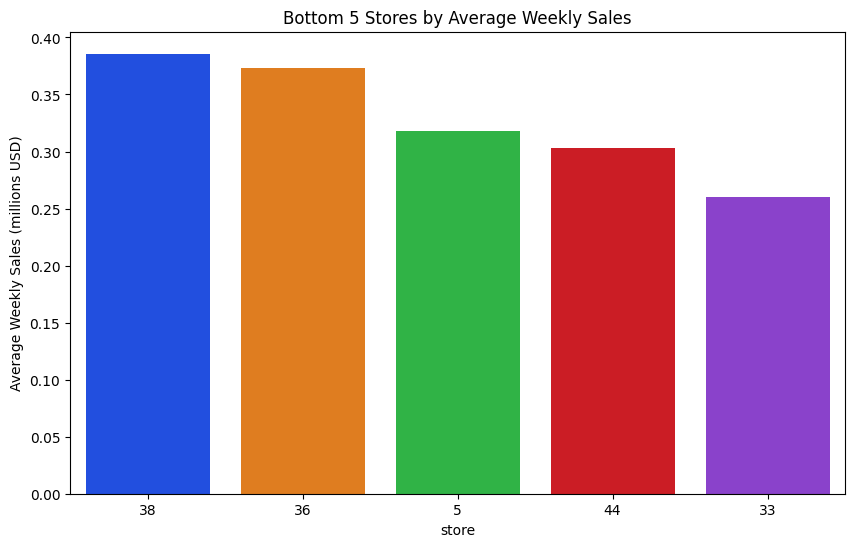

In [223]:
average_sales_by_stores(df, 'store')

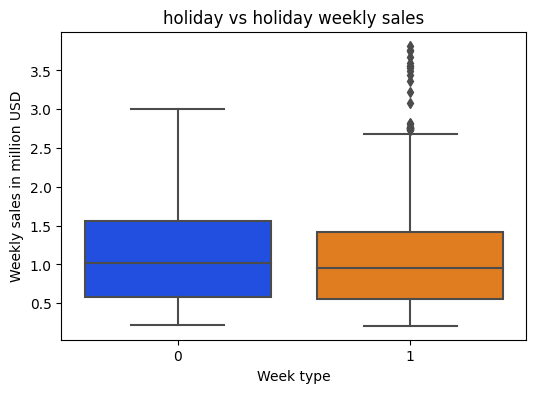

In [228]:
# filter out non-holiday and holiday weekly sales
non_holiday_sales = df[df['holiday_flag'] == 0]
holiday_sales = df[df['holiday_flag'] == 1]

# plot box plots of non-holiday and holiday weekly sales
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=[holiday_sales['weekly_sales']/1e6, non_holiday_sales['weekly_sales']/1e6])
plt.ylabel('Weekly sales in million USD')
plt.xlabel('Week type')
plt.title('holiday vs holiday weekly sales')
plt.show()

<ipython-input-203-bec8f1c8f8af>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,cmap ="YlGnBu")


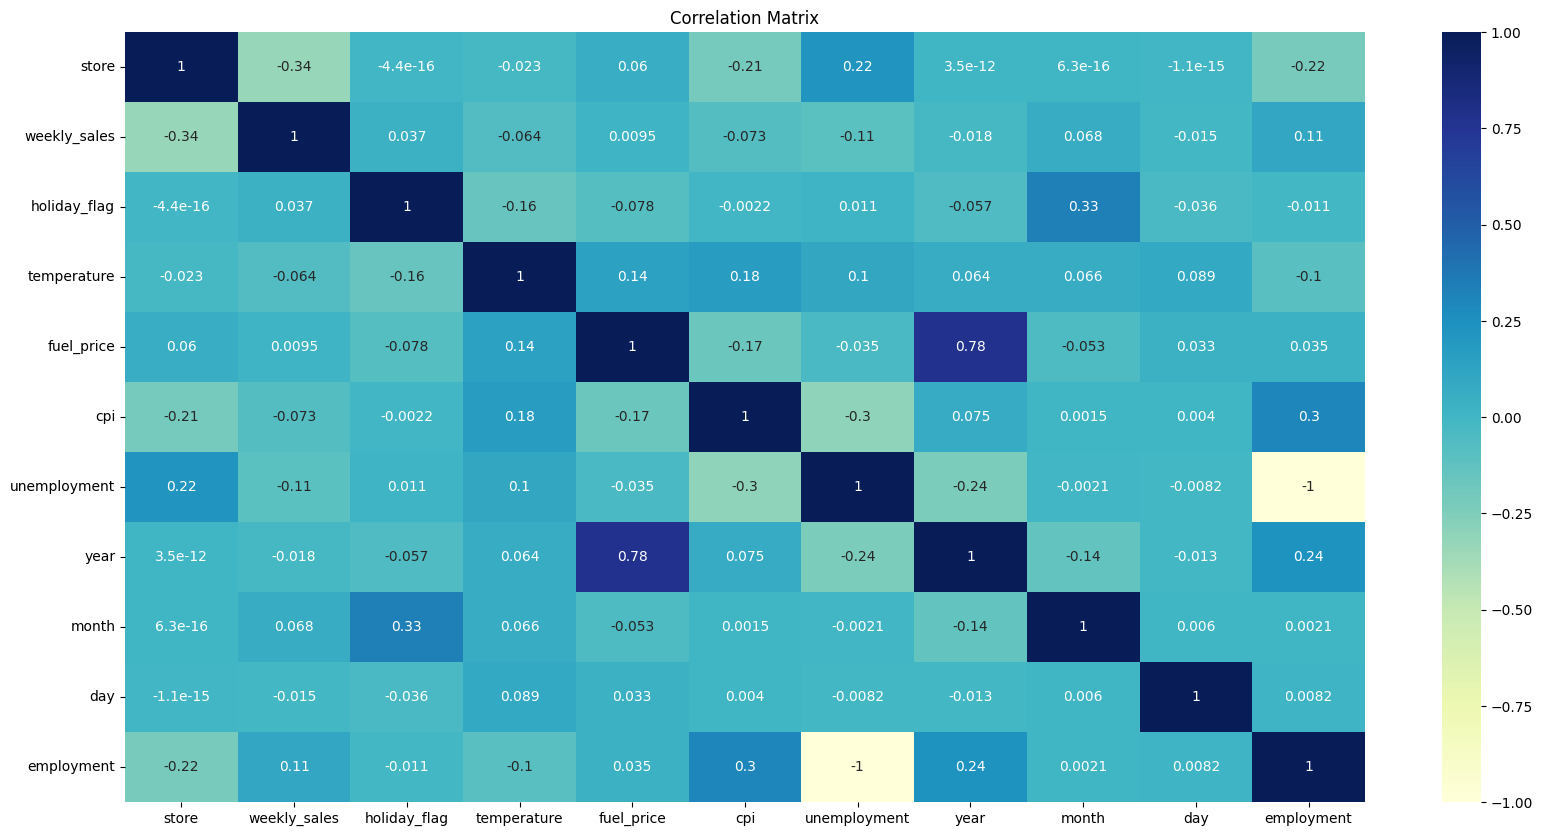

In [203]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(),annot=True,cmap ="YlGnBu")
plt.title('Correlation Matrix')
plt.show()

**Model Selection & Evaluation**

In [317]:
df1 = df.copy()

In [318]:
# drop the date and unemployment columns
df1.drop(['date', 'unemployment'], axis=1, inplace=True)
# check
df1.head()

,store,weekly_sales,holiday_flag,temperature,fuel_price,cpi,year,month,day,employment
0,1,1643690.90,0,42.31,2.572,211.096358,2010,5,2,91.894
1,1,1641957.44,1,38.51,2.548,211.242170,2010,12,2,91.894
2,1,1611968.17,0,39.93,2.514,211.289143,2010,2,19,91.894
3,1,1409727.59,0,46.63,2.561,211.319643,2010,2,26,91.894
4,1,1554806.68,0,46.50,2.625,211.350143,2010,5,3,91.894


In [319]:
# Choose target and feature labels
X = df1.drop('weekly_sales', axis=1)
y = df1['weekly_sales']

In [320]:
print(X, y)

      store  holiday_flag  temperature  fuel_price         cpi  year  month  \
0         1             0        42.31       2.572  211.096358  2010      5   
1         1             1        38.51       2.548  211.242170  2010     12   
2         1             0        39.93       2.514  211.289143  2010      2   
3         1             0        46.63       2.561  211.319643  2010      2   
4         1             0        46.50       2.625  211.350143  2010      5   
...     ...           ...          ...         ...         ...   ...    ...   
6430     45             0        64.88       3.997  192.013558  2012      9   
6431     45             0        64.89       3.985  192.170412  2012      5   
6432     45             0        54.47       4.000  192.327265  2012     12   
6433     45             0        56.47       3.969  192.330854  2012     10   
6434     45             0        58.85       3.882  192.308899  2012     10   

      day  employment  
0       2      91.894  
1  

In [321]:
# scale the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

In [236]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=50)

In [256]:
def model(regressor, X_train, y_train, X_test, y_test):
    # Instantiate the model
    model_instance = regressor()

    # Train the model
    model_instance.fit(X_train, y_train)

    # Predict
    y_pred = model_instance.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Print the model name and metrics in a tabular format
    print(f"{'Model':<30} {'MSE':<15} {'MAE':<15} {'RMSE':<15} {'R2 Score (%)':<15}")
    print(f"{str(model_instance):<30} {mse:<15.2f} {mae:<15.2f} {rmse:<15.2f} {r_squared*100:<15.2f}")
    print('-' * 100)

# Create a list of regressor classes to test
regressor_list = [
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet,
    RandomForestRegressor,
    DecisionTreeRegressor,
    KNeighborsRegressor,
    GradientBoostingRegressor
]

# Calculate metrics for each model
for regressor in regressor_list:
    model(regressor, X_train, y_train, X_test, y_test)


Model                          MSE             MAE             RMSE            R2 Score (%)   
LinearRegression()             271402241219.46 434927.24       520962.80       13.90          
----------------------------------------------------------------------------------------------------
Model                          MSE             MAE             RMSE            R2 Score (%)   
Lasso()                        271402161288.34 434927.24       520962.73       13.90          
----------------------------------------------------------------------------------------------------
Model                          MSE             MAE             RMSE            R2 Score (%)   
Ridge()                        271401686944.35 434928.08       520962.27       13.90          
----------------------------------------------------------------------------------------------------
Model                          MSE             MAE             RMSE            R2 Score (%)   
ElasticNet()                   2

In [ ]:
# Random Forest Regresssor has the lowest MSE, MAE, and RMSE values, indicating that it has the smallest prediction errors and the best overall performance.

In [337]:
# Make predictions on the test data

# Instantiate the Random Forest Regressor
regressor = RandomForestRegressor()

# Train the model on the training data
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
# Now, y_pred contains the predicted values for test data

In [338]:
y_pred

array([2183200.3244, 1420402.2793,  329793.5424, ...,  917181.6457,
        474483.4688,  539878.5364])

In [329]:
# Make predicitons on specific data points
X.values[0].reshape(1, -1).shape

(1, 9)

In [331]:
# Transform new data
regressor.predict(scaler.transform(X.values[0].reshape(1, -1)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1584148.6455])

**Pickle Model for Deployment**

In [334]:
pickle.dump(regressor, open('modelPkl.pkl', 'wb'))

In [339]:
pickled_model = pickle.load(open('modelPkl.pkl', 'rb'))

In [340]:
# Prediction from pickled file
pickled_model.predict(scaler.transform(X.values[0].reshape(1, -1)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1584148.6455])